# LAB3 - Uczenie sieci neuronowych z wykorzystaniem GPU
ver: 6

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl

Celem laboratorium jest porównanie czasu uczenia sieci neuronowych z wykorzystaniem CPU oraz GPU. Przedmiotem uczenia będzie sieć rozpoznająca cyfry pisane odręcznie. W procesie uczenia zostanie wykorzystany zbiór MNIST:

http://yann.lecun.com/exdb/mnist/


Laboratorium może być zrealizowane w dwóch środowiskach pracy:
 * Google Colab w chmurze obliczeniowej;
 * lokalnie na komputerze wyposażonym w GPU.


## Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning

Dostęp do notatnika: https://colab.research.google.com

Włączenie/wyłączenie wsparcia GPU odbywa się poprzez zmianę opcji środowiska uruchomieniowego:
 * Runtime -> Change runtime type -> Hardware accelerator -> None/GPU


## Środowisko pracy - PC + GPU/CUDA + Anaconda

Realizacja laboratorium wymaga Anacondy ze środowiskami:
 * tensorflow
 * tensorflow_gpuenv
 
Różnica pomiędzy nimi polega na wykorzystaniu implementacji biblioteki Tensorflow z NVidia CUDA.

Tworzenie środowisk:
 * wersja z CPU:

```
conda create -n tensorflow_env tensorflow
conda activate tensorflow_env
```

 * wersja z GPU:

```
conda create -n tensorflow_gpuenv tensorflow-gpu
conda activate tensorflow_gpuenv
```

Za pomocą Anaconda Navigator uruchamiamy Jupyter Notebook w konkretnym środowisku - tylko CPU lub ze wsparciem GPU.


## Sieć neuronowa dla zbioru MNIST

Przygotowanie środowiska - należy uruchomić notatnik z obliczeniami wyłącznie na CPU.

In [40]:
try:
  %tensorflow_version 2.x
except:
  pass

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D
from keras.utils import np_utils

plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

In [42]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [43]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Zwizualizuj przykładowe dane.

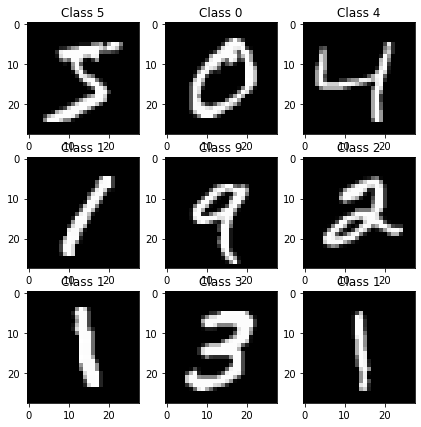

In [44]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

Sieć neuronowa przyjmuje na wejściu obrazek z jednym kanałem - poziomem jasności, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się macierzą 28 x 28 x 1. 

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [45]:
X_train = X_train.reshape(60000, 28,28,1)
X_test = X_test.reshape(10000, 28,28,1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [46]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#Sieć MLP
Zbuduj sieć neuronową. Na potrzeby zajęć sieć będzie posiadała 2 w pełni połączone warstwy. Na wejściu sieci jest macierz z jednym kanałem (28,28,1) dlatego pierwsza warstwa to *Flatten()*.

In [47]:
model = Sequential()
model.add(Flatten(input_shape=(28,28,)))
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax')) # w celu zapewnienia rozkładu wyjść sumującego się do 1

#Sieć CNN
Zbuduj sieć neuronową. Powinna to być sieć LeNet-5 ze zmodyfikowanym rozmiarem wejścia (28,28,1) zamiast (32,32,1).

In [53]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))

model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

#Kompilacja modelu

Kolejnym krokiem jest kompilacja modelu. Biblioteka Keras jest wysokopoziomowym API upraszczającym tworzenie i uczenie sieci neuronowych z wykorzystaniem biblitoeki Tensorflow. Podczas kompilacji sieci, biblioteka Keras wymaga określenia funkcji strat oraz algorytmu optymalizującego proces uczenia.

In [54]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_4 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_5 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_16 (Dense)             (None, 84)               

Po kompilacji modelu sieci neuronowej można przystąpić do uczenia sieci. Ze względu na fakt, że Jupyter notebook został uruchiomy w środowisku z biblioteką Tensorflow bez wsparcia dla GPU, to obliczenia będa wykonywane tylko i wyłącznie na CPU.

In [56]:
import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

In [57]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=16,
          verbose=1,
          validation_data=(X_test, Y_test), callbacks = time_callback)

Epoch 1/16
469/469 [==============================] - 4s 8ms/step - loss: 0.3970 - accuracy: 0.8836 - val_loss: 0.1398 - val_accuracy: 0.9569
Epoch 2/16
469/469 [==============================] - 3s 7ms/step - loss: 0.1165 - accuracy: 0.9646 - val_loss: 0.0792 - val_accuracy: 0.9762
Epoch 3/16
469/469 [==============================] - 3s 7ms/step - loss: 0.0809 - accuracy: 0.9752 - val_loss: 0.0640 - val_accuracy: 0.9797
Epoch 4/16
469/469 [==============================] - 4s 7ms/step - loss: 0.0645 - accuracy: 0.9804 - val_loss: 0.0573 - val_accuracy: 0.9803
Epoch 5/16
469/469 [==============================] - 3s 7ms/step - loss: 0.0539 - accuracy: 0.9828 - val_loss: 0.0637 - val_accuracy: 0.9791
Epoch 6/16
469/469 [==============================] - 3s 7ms/step - loss: 0.0474 - accuracy: 0.9851 - val_loss: 0.0499 - val_accuracy: 0.9817
Epoch 7/16
469/469 [==============================] - 3s 7ms/step - loss: 0.0412 - accuracy: 0.9868 - val_loss: 0.0497 - val_accuracy: 0.9841
Epoch 

In [58]:
times = time_callback.times

print(times)

[3.9095115661621094, 3.4454433917999268, 3.446265697479248, 3.5157992839813232, 3.470479726791382, 3.48116397857666, 3.4777672290802, 3.4959194660186768, 3.5238101482391357, 3.485060691833496, 3.490553855895996, 3.4990530014038086, 3.5264718532562256, 3.493903160095215, 3.4793331623077393, 3.5379490852355957]


## Ewaluacja sieci neuronowej dla zbioru MNIST

Test score: [0.0402972474694252, 0.9879999756813049]


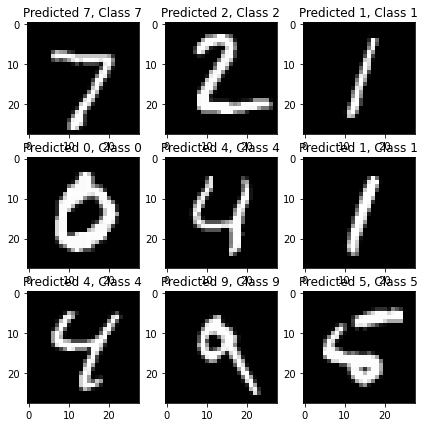

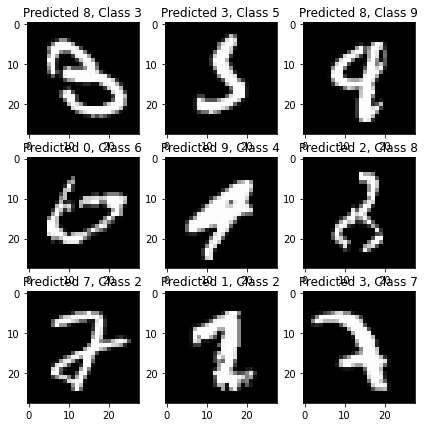

In [59]:
score = model.evaluate(X_test, Y_test,verbose=0)
print('Test score:', score)

predicted_classes = np.argmax(model.predict(X_test), axis=-1)
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## Analiza czasu uczenia sieci z wykorzystaniem CPU oraz przy wsparciu GPU

Uzupełnij poniższy fragment kodu wpisując dane dotyczące czasu obliczeń dla każdej z szesnastu epok uczenia sieci neuronowej.

In [60]:
cpu_epoch_time_MLP = [2.7365548610687256, 2.1659111976623535, 2.228017568588257, 2.1989939212799072, 2.228546619415283, 2.214707136154175, 2.239496946334839, 2.2959768772125244, 2.2398502826690674, 2.263007879257202, 2.224656820297241, 2.2573423385620117, 2.232140064239502, 2.2640366554260254, 2.6596179008483887, 2.5365490913391113]
cpu_accuracy_MLP = 0.9931

cpu_epoch_time_CNN = [4.089617490768433, 3.546412706375122, 3.507059097290039, 3.527902126312256, 3.6646978855133057, 3.5820908546447754, 3.6329867839813232, 3.535179853439331, 3.5915277004241943, 3.5317394733428955, 3.5416932106018066, 3.7721469402313232, 3.5565381050109863, 3.60021710395813, 3.503537893295288, 3.516526222229004]
cpu_accuracy_CNN = 0.9957


Uaktywnij wsparcie GPU dla obliczeń i uruchom ponownie proces uczenia sieci neuronowej na bazie MNIST i uzupełnij fragment kodu poniżej.

W przypadku środowiska Anaconda zamknij środowisko *tensorflow\_env* i uruchom środowisko *tensorflow\_gpuenv*. W przypadku Google Colab zmień ustawienia środowiska uruchomieniowego.



In [61]:
gpu_epoch_time_MLP = [2.8998782634735107, 2.238100290298462, 2.2506368160247803, 2.330791473388672, 2.185788869857788, 2.2326033115386963, 2.272249937057495, 2.288484573364258, 2.280461072921753, 2.2774710655212402, 2.299339532852173, 2.2180182933807373, 2.247863531112671, 2.33193039894104, 2.3046836853027344, 2.300619125366211]
gpu_accuracy_MLP = 0.9935

gpu_epoch_time_CNN = [3.9095115661621094, 3.4454433917999268, 3.446265697479248, 3.5157992839813232, 3.470479726791382, 3.48116397857666, 3.4777672290802, 3.4959194660186768, 3.5238101482391357, 3.485060691833496, 3.490553855895996, 3.4990530014038086, 3.5264718532562256, 3.493903160095215, 3.4793331623077393, 3.5379490852355957]
gpu_accuracy_CNN = 0.9953

Zwizualizuj i przeanalizuj czas uczenia sieci neuronowej z CPU i GPU.

{'whiskers': [<matplotlib.lines.Line2D at 0x1bd4ba6b310>,
 'caps': [<matplotlib.lines.Line2D at 0x1bd4ba6b9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bd4ba5af40>,
 'medians': [<matplotlib.lines.Line2D at 0x1bd4ba780d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1bd4ba78430>,
 'means': []}

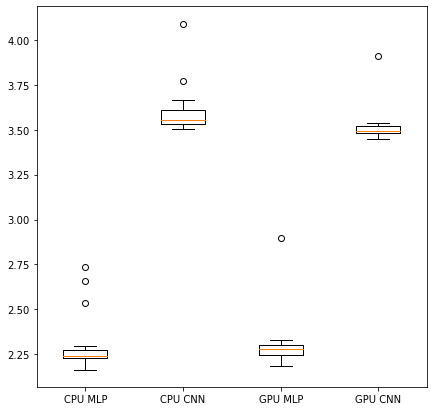

In [62]:
plt.boxplot([cpu_epoch_time_MLP, cpu_epoch_time_CNN, gpu_epoch_time_MLP, gpu_epoch_time_CNN], labels=['CPU MLP', 'CPU CNN', 'GPU MLP', 'GPU CNN'])


**Wnioski**

* Jeśli chodzi o MLP, to szybsze było podejście wykorzystujące CPU (natomiast mniej dokładne). W przypadku CNN szybsze okazało się być podejście z GPU, ale mniej dokładne od podejścia z CPU.

* GPU - Intel(R) UHD Graphics 630, pamięć procesora: 7.9 GB
* CPU - Intel(R) Core(TM) i7-10700T CPU @ 2.00GHz, rdzenie: 8



## Mikołaj Sikora